In [1]:
## IMPORT NECESSARY LIBRARIES

from spectral import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import glob 
from hsi_detect.utils

# The Goal of this first section will be to familiarize ourselves with input and output of HSI images into Python and analyzing them. 

### The first exercise will be to Compare the Reflectance image output by the IQ camera and one calculated from the raw image

## Reading in hyperspectral image files

Typically, a lab image will come with a data file and a corresponding .hdr file.

The .hdr file contains the information about the data file that is needed to read it.
For many software (and python) the .hdr filepath is provided as input, but the datafile must be in the same directory.


In [2]:
HDR_PATH = 'data/input/087_ELOP Eden Fleshler/results/REFLECTANCE_087.hdr'
RAW_DIRECTORY = 'data/input/087_ELOP Eden Fleshler/capture/'

# lib = envi.open('data/input/088_ELOP Eden Fleshler/results/REFLECTANCE_088.hdr')

lib = envi.open(HDR_PATH)

raw_imgs = glob.glob(RAW_DIRECTORY + '*.hdr')
for raw_img in raw_imgs:
  if 'DARKREF' in raw_img:
    print ('dark reference found at', raw_img)
    dark_ref = envi.open(raw_img)
  elif 'WHITEREF' in raw_img:
    print ('white reference found at', raw_img)
    white_ref = envi.open(raw_img)
  else:
    print ('raw image found at', raw_img)
    raw_lib = envi.open(raw_img)

# lib = envi.open('../../from_box/Grad/research/bioHSI/04_image_processing/00_data/rg_on_sand_induction_54m/raw_0_rd_rf_or.hdr')

raw image found at data/input/087_ELOP Eden Fleshler/capture/087.hdr
dark reference found at data/input/087_ELOP Eden Fleshler/capture/DARKREF_087.hdr
white reference found at data/input/087_ELOP Eden Fleshler/capture/WHITEREF_087.hdr


In [3]:
# Loads the whole image
hsi_img = lib.load()


In [4]:
print("Shape of HSI image:", hsi_img.shape)

Shape of HSI image: (512, 512, 204)


In [5]:
# .bands.centers is an array of the center wavelengths of the bands in the image
centers = hsi_img.bands.centers
print(len(centers), 'bands in image')
print('First 5:', 'nm, '.join(map(str,centers[:5])))

204 bands in image
First 5: 397.32nm, 400.2nm, 403.09nm, 405.97nm, 408.85


In [6]:
# We can define a funciton to convert HSI images to RGB images 

def get_rgb(hsi_img, centers, r=650, g=550, b=450):
  """
  Get a false RGB image from a HSI iamge
  """
  band_wavelengths = np.array(centers)

  # Find the indices of the bands that are closest to the red, green, and blue wavelengths
  red_idx = np.argmin(np.abs(band_wavelengths - r)) 
  green_idx = np.argmin(np.abs(band_wavelengths - g))
  blue_idx = np.argmin(np.abs(band_wavelengths - b))
  
  rgb = hsi_img[:,:,[red_idx, green_idx, blue_idx]]
  return rgb

def show(img, **fig_kwargs):
  plt.figure(**fig_kwargs)
  plt.imshow(img)
  plt.box(False)
  plt.xticks([])
  plt.yticks([])


def norm(spectrum):
  return spectrum / np.nanmax(spectrum, keepdims=True)

In [7]:
# call the function 
rgb_img = get_rgb(hsi_img, centers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


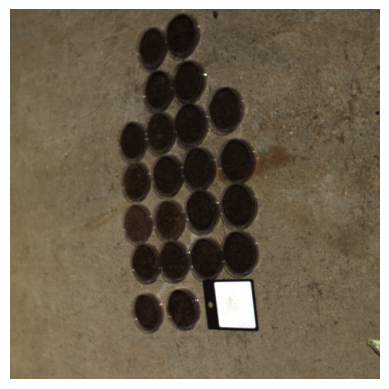

In [8]:
show(rgb_img)

In [9]:
# plotly called with px.ffff is a library for interactive plots in Python.
# This makes interacting with images easier
# Displaying images in plotly has some quirks as it expects the values to be 
# integers between 0 and 255
# Additionally, pixels that exceed 255 should be capped at 255 or they will not
# display correctly 

converted_rgb_img = np.minimum(rgb_img*255, 255).astype(np.uint8)

px.imshow(converted_rgb_img)

In [10]:
#Load in the data needed for the correction

raw_img = raw_lib.load()
dark_ref_img = dark_ref.load()
white_ref_img = white_ref.load()

print("Shape of raw image:", raw_img.shape)
print("Shape of dark reference image:", dark_ref_img.shape)
print("Shape of white reference image:", white_ref_img.shape)


Shape of raw image: (512, 512, 204)
Shape of dark reference image: (1, 512, 204)
Shape of white reference image: (1, 512, 204)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

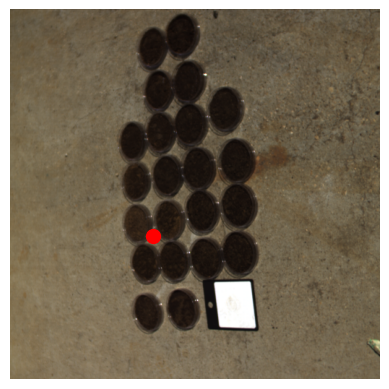

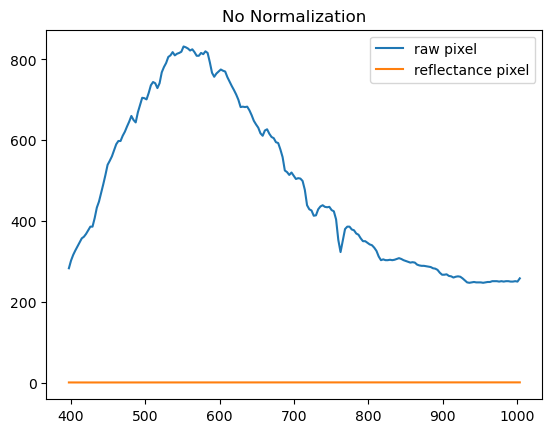

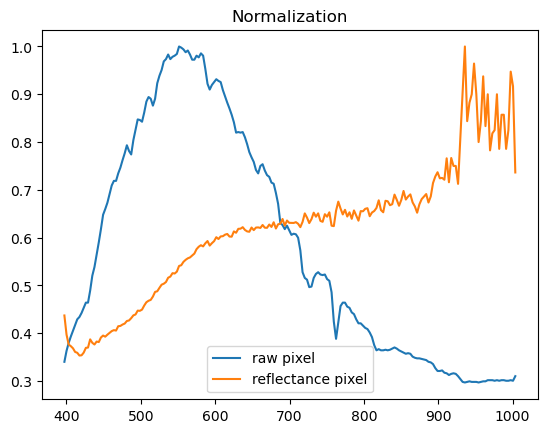

In [11]:
# COMPARE A RAW AND REFLECTANCE PIXEL
COORDINATE = [313, 198]#Y, X

plt.figure()
show(rgb_img)
plt.scatter(COORDINATE[1], COORDINATE[0], color='red', s=100)
plt.show()

plt.figure()
plt.title('No Normalization')
plt.plot(lib.bands.centers, raw_img[COORDINATE[0], COORDINATE[1], :].squeeze(), label='raw pixel')
plt.plot(lib.bands.centers, hsi_img[COORDINATE[0], COORDINATE[1], :].squeeze(), label='reflectance pixel')
plt.legend()
plt.show()

plt.figure()
plt.title('Normalization')
plt.plot(lib.bands.centers, norm(raw_img[COORDINATE[0], COORDINATE[1], :].squeeze()), label='raw pixel')
plt.plot(lib.bands.centers, norm(hsi_img[COORDINATE[0], COORDINATE[1], :].squeeze()), label='reflectance pixel')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


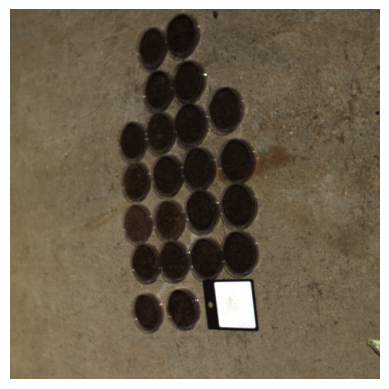

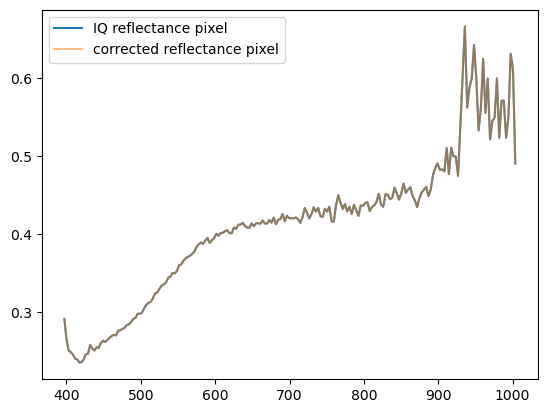

In [18]:
### Matching dimensions takes some getting used to. 
# Numpy will try to automatically "cast", so subtracting a nparray with dimension
# (1, X, L) from one with dimensions (Y, X, L) will substract the vector from each 
# of the Y (X, L) vectors

# Calculate the reflectance image
# reflectance_img = (raw_img - dark_ref_img) / (white_ref_img - dark_ref_img)

corrected_img = (raw_img - dark_ref_img) / (white_ref_img - dark_ref_img)

show(get_rgb(corrected_img, centers))

plt.figure()
plt.plot(lib.bands.centers, hsi_img[COORDINATE[0], COORDINATE[1], :].squeeze(), label='IQ reflectance pixel')
plt.plot(lib.bands.centers, corrected_img[COORDINATE[0], COORDINATE[1], :].squeeze(), label='corrected reflectance pixel', alpha=0.5)
plt.legend()
plt.show()

# They should overlap 


#### So far we have learned to open an image, select a pixel, and perform basic image corrections. 

## Now we will open a pre-defined reference spectrum

Before interpolation, the reference spectrum has (371,) values
After interpolation, the reference spectrum has (204,) values


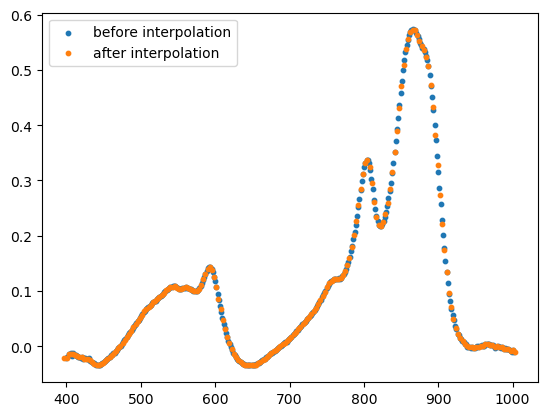

In [20]:
import pandas as pd
reference_spectrum_data = pd.read_csv('data/bchl_spectrum_infered_from_YF10_pellets.csv')

reference_spectrum = reference_spectrum_data['absorbance'].values
plt.scatter(reference_spectrum_data['wavelength'].values, reference_spectrum, label='before interpolation', s=10)
print('Before interpolation, the reference spectrum has', reference_spectrum.shape, 'values')

# interpolate the reference spectrum to the HSI bands
reference_spectrum = np.interp(hsi_img.bands.centers, reference_spectrum_data['wavelength'], reference_spectrum)
plt.scatter(hsi_img.bands.centers, reference_spectrum, label='after interpolation', s=10)
print('After interpolation, the reference spectrum has', reference_spectrum.shape, 'values')
plt.legend()
plt.show()

The maximum absorbance is at 865.5 nm and it is being compared to: 896.01 nm


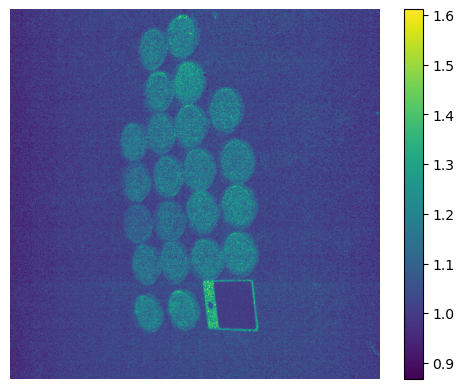

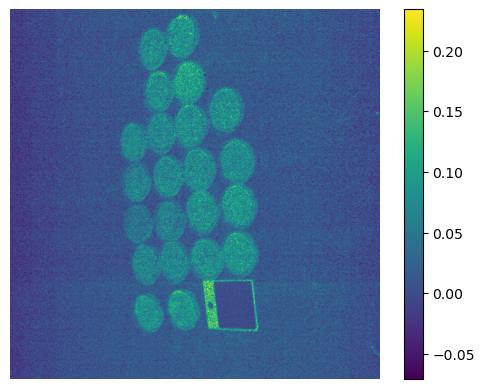

In [22]:
# from the reference spectrum we can now calculate the ratio image

max_abs_idx = np.argmax(reference_spectrum)
min_abs_idx = max_abs_idx+10#np.argmin(reference_spectrum)
print ('The maximum absorbance is at', hsi_img.bands.centers[max_abs_idx], 'nm and it is being compared to:', hsi_img.bands.centers[min_abs_idx], 'nm')

# calculate a RATIO image
ratio_img = hsi_img[:,:,min_abs_idx]/hsi_img[:,:,max_abs_idx]

# calculate a Normalized Difference Index Image
ndi_img = (hsi_img[:,:,min_abs_idx]-hsi_img[:,:,max_abs_idx])/(hsi_img[:,:,min_abs_idx]+hsi_img[:,:,max_abs_idx])

show(ratio_img)
plt.colorbar()
plt.show()

show(ndi_img)
plt.colorbar()
plt.show()

In [23]:
# get the highest percentile from the ratio image and set it as a threshold
top_percentile = np.nanpercentile(ratio_img, 90)
print (top_percentile)
threshed_img = ratio_img.copy()
threshed_img[threshed_img < top_percentile] = np.nan
px.imshow((255*np.concatenate([threshed_img]*3, axis=2)).astype(np.uint8))

1.1369168758392334


In [24]:
# Define the "target" pixel 
# This should be the pixel with the signal on it 

# Whether to take an average of a set of pixels around target
AVERAGE_TARGET = True
# Y, X where [0,0] is top left corner of image
TARGET_COORDS = [224,316]

BG_COORDS = [414,490,55,191] 
bg_stats = calc_stats(hsi_img[BG_COORDS[0]:BG_COORDS[1], BG_COORDS[2]:BG_COORDS[3]])


if AVERAGE_TARGET:
    target = np.nanmean(hsi_img[TARGET_COORDS[0]-3:TARGET_COORDS[0]+3:, TARGET_COORDS[1]-3:TARGET_COORDS[1]+3,:], axis=(0,1))
else:
    target = hsi_img[TARGET_COORDS[0], TARGET_COORDS[1],:]


# Perform ACE (adaptive coherence estimation) and MF (matched filter) classification
try:
    acescores = ace(hsi_img, target, background=bg_stats)
except:
    print ('Calculating ACE scores failed')
    acescores = np.zeros((hsi_img.shape[0], hsi_img.shape[1]))

mfscores = matched_filter(hsi_img, target, background=bg_stats)

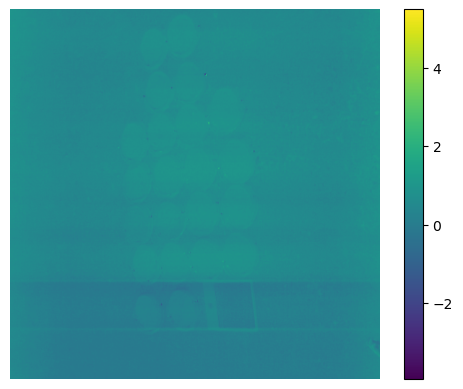

In [25]:
mfscores[(hsi_img[:,:,100]==0)[:,:,0]]=np.nan
plt.imshow(mfscores)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.box()

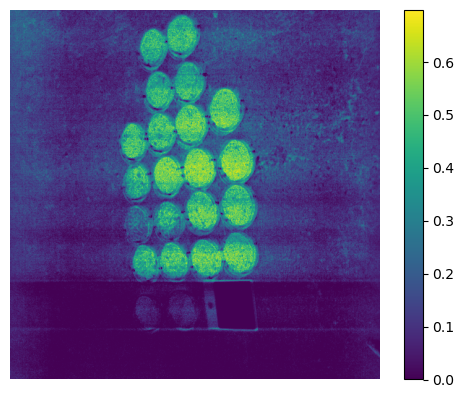

In [26]:
acescores[(hsi_img[:,:,100]==0)[:,:,0]]=np.nan
plt.imshow(acescores)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.box()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

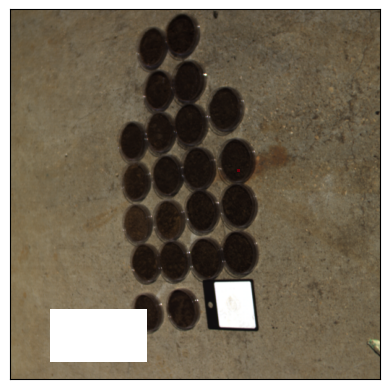

In [35]:
acescores[(hsi_img[:,:,100]==0)[:,:,0]]=np.nan

target_mask = np.zeros_like(hsi_img[:,:,0])*np.nan
target_mask[TARGET_COORDS[0]-3:TARGET_COORDS[0]+3:, TARGET_COORDS[1]-3:TARGET_COORDS[1]+3] = 1

bg_mask = np.zeros_like(hsi_img[:,:,0])*np.nan
bg_mask[BG_COORDS[0]:BG_COORDS[1], BG_COORDS[2]:BG_COORDS[3]] = 1

plt.imshow(rgb_img)
plt.imshow(bg_mask, cmap='Greys')
plt.imshow(target_mask, cmap='Reds_r')
plt.xticks([])
plt.yticks([])
# plt.colorbar()


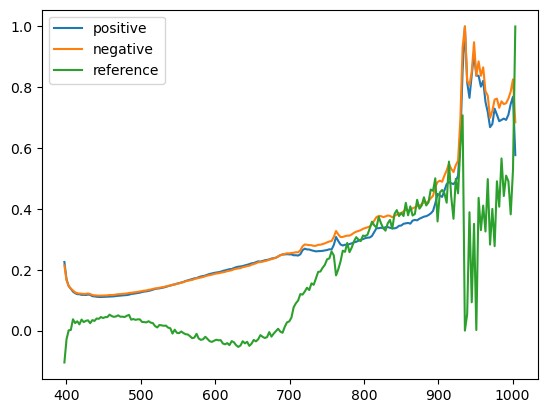

In [53]:
### Define a custom reference spectrum 

AVERAGING_RADIUS = 3

#Y,
positive_coord = [418, 196]
negative_coord = [228,263]


positive_spectrum = hsi_img[positive_coord[0]-AVERAGING_RADIUS:positive_coord[0]+AVERAGING_RADIUS, positive_coord[1]-AVERAGING_RADIUS:positive_coord[1]+AVERAGING_RADIUS, :].mean(axis=(0,1))
negative_spectrum = hsi_img[negative_coord[0]-AVERAGING_RADIUS:negative_coord[0]+AVERAGING_RADIUS, negative_coord[1]-AVERAGING_RADIUS:negative_coord[1]+AVERAGING_RADIUS, :].mean(axis=(0,1))
reference_spectrum = norm(negative_spectrum) - norm(positive_spectrum)

plt.plot(hsi_img.bands.centers, norm(positive_spectrum), label='positive')
plt.plot(hsi_img.bands.centers, norm(negative_spectrum), label='negative')
plt.plot(hsi_img.bands.centers, norm(reference_spectrum), label='reference')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


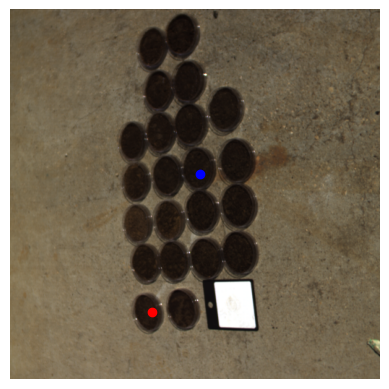

In [48]:
show(rgb_img)
plt.plot(positive_coord[1], positive_coord[0], 'ro')
plt.plot(negative_coord[1], negative_coord[0], 'bo')
plt.show()

# calculate reflectance as (img - dark) / (white - dark)




In [54]:
# Save the reference spectrum
np.save('reference_spectrum.npy', np.stack([centers, reference_spectrum], axis=1))

In [57]:
from hsi_detect.spectrum import Spectrum
from hsi_detect.image import HyperspectralImage
from hsi_detect.classifier import HierarchicalKMeansUnmixer
from hsi_detect.utils import *
import os

In [59]:
savedir = '/'.join(['data', 'outputs'])

print ('Saving to', savedir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
    print ('Made directory:', savedir)

Saving to data/outputs


In [ ]:
# Smooth the image spectrum using sliding window averaging
hsi_img = HyperspectralImage(HDR_PATH, smoothing_window=11)
hsi_img.show(dpi=300, savepath=savedir+f'reconstructed_RGB.png')

# Load and visualize the spectrum of the HSR
reference_spectrum = Spectrum('00_data/absorbance_data/YF10_infered_absorbance_from_pellets_09Jul2024.npy')
reference_spectrum.interpolate_spectrum(hsi_img.centers) #Interpolate spectrum to fit the HSI
reference_spectrum.show()